In [1]:
import maxentep
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.stats as ss
plt.style.use('seaborn-darkgrid')
# disabling gpu for now
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

## Set-up Initial Guesses

In [2]:
M = 4
R = np.abs(np.random.normal(size=(M,M), loc=1.25))
R = R / np.sum(R, axis=1).reshape(M,1)
R, np.sum(R, axis=1)

(array([[0.46650917, 0.08779758, 0.00935033, 0.43634292],
        [0.33961044, 0.00503527, 0.23135713, 0.42399716],
        [0.1696625 , 0.09625968, 0.42323959, 0.31083824],
        [0.19508873, 0.33792093, 0.46301675, 0.00397359]]),
 array([1., 1., 1., 1.]))

In [3]:
# compartment parameters
compartments = ['E', 'A', 'I', 'R']
infections_compartments = [1,2]
C = len(compartments)
tmat = maxentep.TransitionMatrix(1.0, compartments)
tmat.add_norm_dist('E', 'A', 5, 2)
tmat.add_norm_dist('A', 'I', 3, 2)
tmat.add_norm_dist('I', 'R', 14, 4)
T = tmat.sample(1)[0]
np.sum(T, axis=1)

array([1., 1., 1., 1.])

In [4]:
start = np.zeros((M, C))
start[0, 1] = 0.1
infect = maxentep.contact_infection_func(0.1,infections_compartments)

## Build Metapopulation Keras Model

In [5]:
init_R, init_T, init_start = R, T, start

R_layer = maxentep.TrainableInputLayer(init_R, maxentep.NormalizationConstraint(1))
T_layer = maxentep.TrainableInputLayer(init_T, maxentep.NormalizationConstraint(1))
start_layer = maxentep.TrainableInputLayer(init_start, tf.keras.constraints.MaxNorm(max_value=0.2, axis=-1))
start_layer(0)

<tf.Tensor: shape=(1, 4, 4), dtype=float32, numpy=
array([[[0. , 0.1, 0. , 0. ],
        [0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. ]]], dtype=float32)>

In [7]:
metapop_layer = maxentep.MetapopLayer(250, (M, C), infect)(R_layer(0), T_layer(0), start_layer(0))
final = maxentep.AddSusceptibleLayer()(metapop_layer)

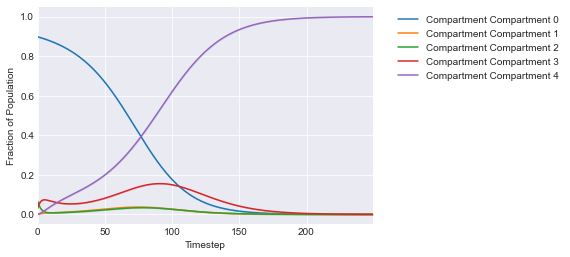

In [9]:
maxentep.traj_quantile(final.numpy()[:, :, 0, :])